# Zeta Disease Prediction

Mars Mission Control needs a good data-driven system for predicting Zeta Disease infection on the International Mars Colony.
Use the `zeta-disease_training-data` dataset to build a model that can predict who will be infected by Zeta Disease.
Train and apply a model to the `zeta-disease_prediction-data` dataset to predict who will be infected by Zeta Disease.

The dataset includes 9 columns with information on 800 people.
1.	age : in years
2.	weight : body weight in pounds (lbs)
3.	bmi : Body Mass Index (weight in kg/(height in m)2)
4.	blood_pressure : resting blood pressure (mm Hg)
5.	insulin_test : inuslin test value
6.	liver_stress_test : liver_stress_test value
7.	cardio_stress_test : cardio_stress_test value
8.	years_smoking : number of years of smoking
9.	zeta_disease :
              1 = yes;
              0 = no

## Notebook Config

In [1]:
%config Completer.use_jedi = False

## Import data

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train_data_filepath = "./data/zeta-disease_training-data.csv"
test_data_filepath = "./data/zeta-disease_prediction-data.csv"
output_filepath = './predictions/lr_pred.csv'

In [4]:
train_df = pd.read_csv(train_data_filepath)
test_df = pd.read_csv(test_data_filepath)

In [5]:
train_df.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,54,189,27.1,80,0,1.5038,0,10,0
1,23,150,38.5,68,71,0.3868,55,2,0
2,47,186,29.9,90,0,0.2728,0,7,0
3,18,150,30.8,70,1033,0.6598,56,0,0
4,24,160,32.4,74,125,0.7608,59,2,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 800 non-null    int64  
 1   weight              800 non-null    int64  
 2   bmi                 800 non-null    float64
 3   blood_pressure      800 non-null    int64  
 4   insulin_test        800 non-null    int64  
 5   liver_stress_test   800 non-null    float64
 6   cardio_stress_test  800 non-null    int64  
 7   years_smoking       800 non-null    int64  
 8   zeta_disease        800 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.4 KB


In [7]:
test_df.head()

,age,weight,bmi,blood_pressure,insulin_test,liver_stress_test,cardio_stress_test,years_smoking,zeta_disease
0,24,151,39.5,69,72,1.3968,56,4,NaN
1,27,179,35.5,89,156,1.6608,43,6,NaN
2,34,147,26.9,76,74,1.6958,53,2,NaN
3,35,206,32.4,73,127,1.4608,61,6,NaN
4,60,193,29.8,62,192,1.7798,65,9,NaN


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 20 non-null     int64  
 1   weight              20 non-null     int64  
 2   bmi                 20 non-null     float64
 3   blood_pressure      20 non-null     int64  
 4   insulin_test        20 non-null     int64  
 5   liver_stress_test   20 non-null     float64
 6   cardio_stress_test  20 non-null     int64  
 7   years_smoking       20 non-null     int64  
 8   zeta_disease        0 non-null      float64
dtypes: float64(3), int64(6)
memory usage: 1.5 KB


In [9]:
test_df.drop("zeta_disease", axis=1, inplace=True)

## Data Visualization

In [10]:
import sweetviz as sv

In [11]:
data_report = sv.compare([train_df, "Training data"], [test_df, "Test data"], "zeta_disease")

                                             |                                                                …

In [12]:
data_report.show_html(filepath="html-exports/train_test_compare.html")

Report html-exports/train_test_compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Data pre-processing

The features in the dataset are measured in different units and scales. Stardardizing the features will help with analyzing the influence of each feature on a comparable scale.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
X = train_df.drop("zeta_disease", axis=1)
y = train_df["zeta_disease"]

In [15]:
scaler = StandardScaler()
train_scaled_data = scaler.fit_transform(X)
train_scaled_df = pd.DataFrame(train_scaled_data, columns=X.columns)
train_scaled_df["zeta_disease"] = y

In [16]:
scaled_data_report = sv.analyze(train_scaled_df, "zeta_disease")

                                             |                                                                …

In [17]:
scaled_data_report.show_html(filepath="html-exports/train_scaled_data.html")

Report html-exports/train_scaled_data.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [18]:
X_scaled = train_scaled_df.drop("zeta_disease", axis=1)

## Model selection

In [19]:
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [21]:
RANDOM_STATE = 101

In [22]:
classifiers = {
    "LogReg": LogisticRegression(random_state=RANDOM_STATE, max_iter=500, class_weight="balanced"),
    "SVM": SVC(random_state=RANDOM_STATE, class_weight="balanced"),
    "RF": RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "XGB": XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss")
}

In [23]:
# 80-20 Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, random_state=RANDOM_STATE,
                                                  test_size=0.2, shuffle=True, stratify=y)

print(X_train.shape)
print(X_val.shape)

(640, 8)
(160, 8)


In [24]:
results = {}
for name, clf in classifiers.items():
    print(f"Training classifier: {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    report = classification_report(y_val, y_pred)
    results[name] = report

Training classifier: LogReg
Training classifier: SVM
Training classifier: RF
Training classifier: XGB


Results of LogReg:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       104
           1       0.67      0.73      0.70        56

    accuracy                           0.78       160
   macro avg       0.76      0.77      0.76       160
weighted avg       0.79      0.78      0.78       160




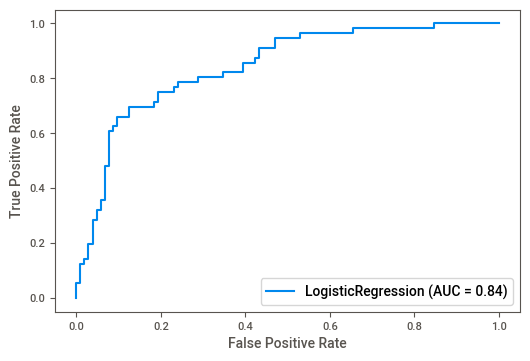

Results of SVM:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       104
           1       0.59      0.71      0.65        56

    accuracy                           0.73       160
   macro avg       0.71      0.72      0.71       160
weighted avg       0.74      0.72      0.73       160




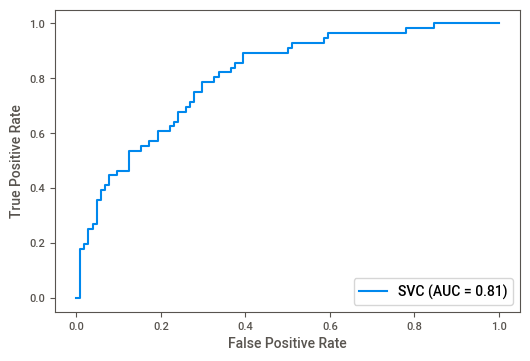

Results of RF:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       104
           1       0.79      0.61      0.69        56

    accuracy                           0.81       160
   macro avg       0.80      0.76      0.77       160
weighted avg       0.80      0.81      0.80       160




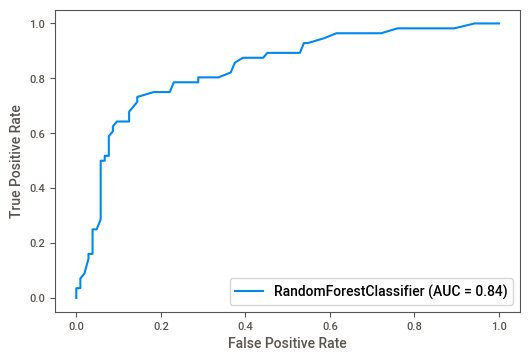

Results of XGB:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       104
           1       0.65      0.66      0.65        56

    accuracy                           0.76       160
   macro avg       0.73      0.73      0.73       160
weighted avg       0.76      0.76      0.76       160




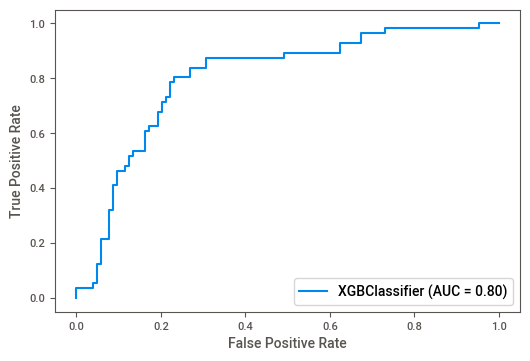

In [25]:
for k, v in results.items():
    print(f"Results of {k}:")
    print(f"{v}\n")
    plot_roc_curve(classifiers[k], X_val, y_val)
    plt.show()

Of all the models tried the linear models seems to perform at par with the more complex models.

## Hyperparameter tuning

The logistic regression model can be regularised to produce a sparse model and avoid overfitting.

In [26]:
from sklearn.linear_model import LogisticRegressionCV

In [27]:
model_logistic = LogisticRegressionCV(Cs=5, cv=10, max_iter=1000, class_weight="balanced")

In [28]:
model_logistic.fit(X_train, y_train)

LogisticRegressionCV(Cs=5, class_weight='balanced', cv=10, max_iter=1000)

In [29]:
model_logistic.C_

array([1.])

In [30]:
y_train_pred = model_logistic.predict(X_train)
y_val_pred = model_logistic.predict(X_val)

In [31]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       104
           1       0.67      0.73      0.70        56

    accuracy                           0.78       160
   macro avg       0.76      0.77      0.76       160
weighted avg       0.79      0.78      0.78       160



## Threshold tuning

The resulting logistic model is applied to the disease prediction task after a trade-off between sensitivity and specificity of the model.

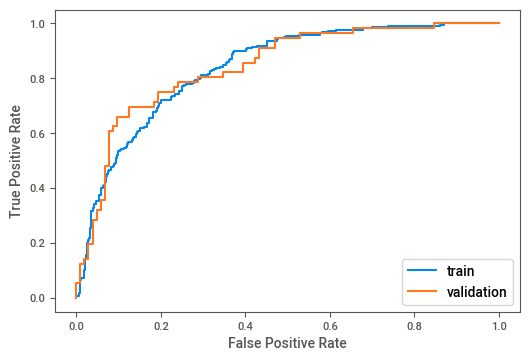

In [32]:
fig, ax = plt.subplots()
plot_roc_curve(model_logistic, X_train, y_train, ax=ax, label="train")
plot_roc_curve(model_logistic, X_val, y_val, ax=ax, label="validation")
plt.show()

In [33]:
fpr, tpr, thresholds = roc_curve(y_val, model_logistic.predict_proba(X_val)[:, 1])
gmeans = (tpr * (1-fpr))**0.5
idx = gmeans.argmax()
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[idx], gmeans[idx]))

Best Threshold=0.638933, G-Mean=0.781


## Model explanation

In [34]:
coef = pd.DataFrame(model_logistic.coef_, columns=X_train.columns).squeeze()
coef

age                   0.265467
weight                1.128414
bmi                   0.645867
blood_pressure       -0.175083
insulin_test         -0.161047
liver_stress_test     0.404647
cardio_stress_test    0.043771
years_smoking         0.384086
Name: 0, dtype: float64

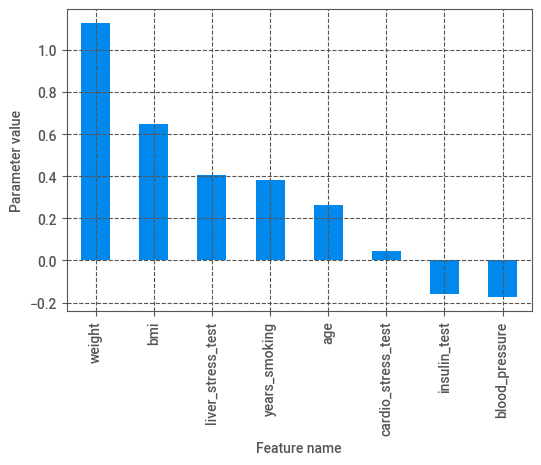

In [35]:
fig, ax = plt.subplots()
coef.sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.grid(linestyle='--')
ax.set_ylabel("Parameter value")
ax.set_xlabel("Feature name")
plt.setp(ax.get_xmajorticklabels(), size=10)
plt.setp(ax.get_ymajorticklabels(), size=10)
plt.show()

In [36]:
import shap
shap.initjs()

In [37]:
explainer = shap.Explainer(model_logistic, X_train, feature_names=X_train.columns)
shap_values_val = explainer(X_val)

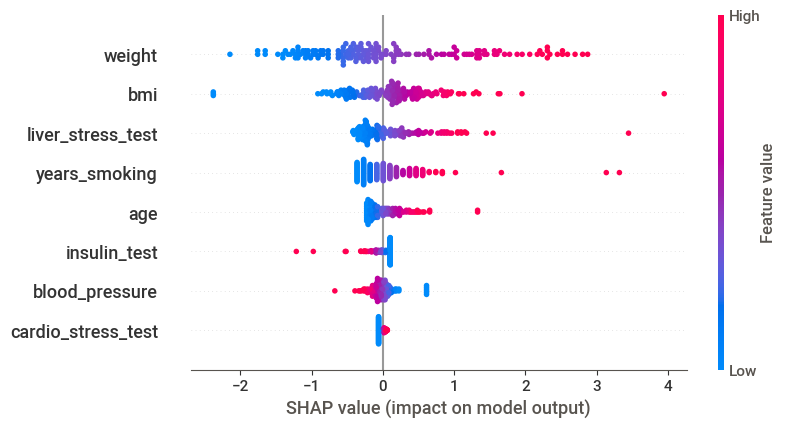

In [38]:
shap.plots.beeswarm(shap_values_val)

Persons with high body weight and BMI are more prone to be diagnosed with zeta disease. Smokers, persons with low blood pressure are also more likely to test positive for zeta disease.

 ## Predict

In [39]:
X_test = scaler.transform(test_df[X_scaled.columns])

In [40]:
test_df["zeta_disease"] = model_logistic.predict(X_test)

In [41]:
shap_values_test = explainer(X_test)

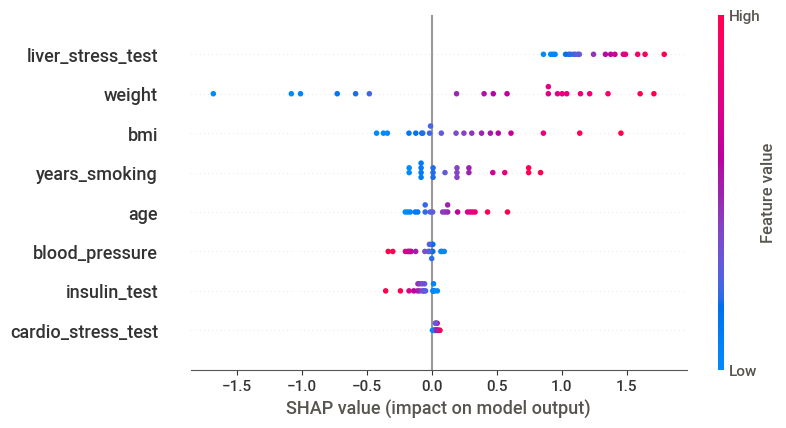

In [42]:
shap.plots.beeswarm(shap_values_test)

In [43]:
if not os.path.exists(output_filepath):
    os.makedirs(os.path.dirname(output_filepath))

test_df.to_csv(output_filepath, index=False)